In [ ]:
#importing the required libraries 
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML


In [ ]:

BATCH_SIZE = 32 
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50


In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/yesaswimadabattula/Documents/potato_disease_detection/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
class_names


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())


(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


2025-06-25 11:40:09.535201: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-06-25 11:40:17.600131: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


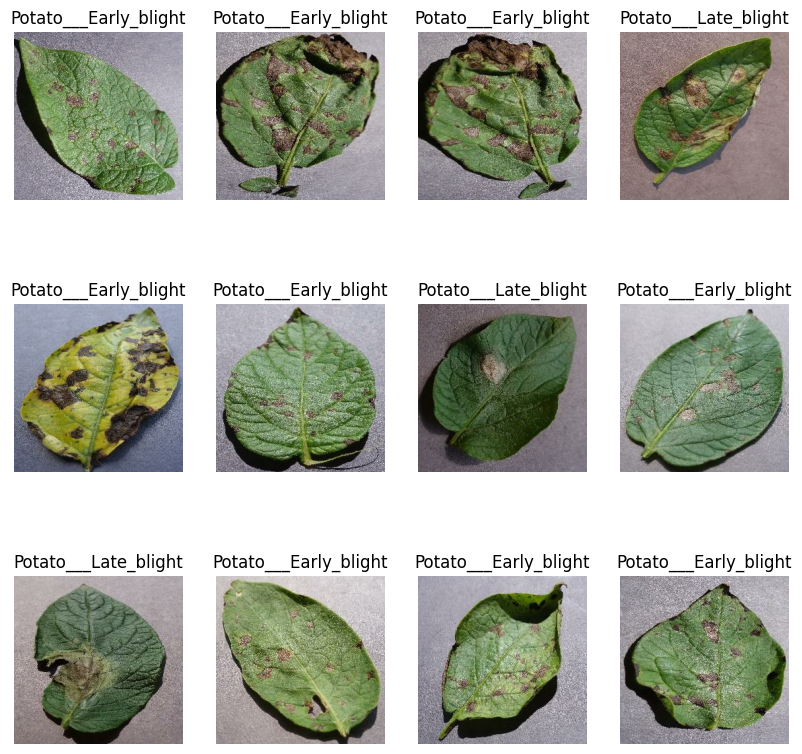

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [12]:
len(dataset)

68

In [14]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [15]:
train_ds=dataset.take(54)
len(train_ds)

54

In [18]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [19]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [20]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [21]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [22]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert (train_split+test_split + val_split)==1
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split * ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [23]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)


In [24]:
len(train_ds)

54

In [25]:
len(val_ds)

6

In [26]:
len(test_ds)

8

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#when the cpu is busy with the other work the it will assignto the next batch of the cpu

In [ ]:
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])
# resizing the images to 256*256
 # and 
 


In [ ]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

# flipping the image to get diverse dataset 

In [34]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [35]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


/Users/yesaswimadabattula/Documents/potato_disease_detection/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [39]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 719ms/step - accuracy: 0.4602 - loss: 0.9197 - val_accuracy: 0.7031 - val_loss: 0.7003
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 718ms/step - accuracy: 0.7217 - loss: 0.6745 - val_accuracy: 0.8073 - val_loss: 0.3997
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 695ms/step - accuracy: 0.8401 - loss: 0.3766 - val_accuracy: 0.8802 - val_loss: 0.2923
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 683ms/step - accuracy: 0.8919 - loss: 0.2589 - val_accuracy: 0.8594 - val_loss: 0.3914
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 687ms/step - accuracy: 0.9239 - loss: 0.1934 - val_accuracy: 0.8333 - val_loss: 0.3369
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 774ms/step - accuracy: 0.9072 - loss: 0.2227 - val_accuracy: 0.9271 - val_loss: 0.1823
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 735ms/step - accuracy: 0.9331 - loss: 0.1765 - val_accuracy: 0.9115 - val_loss: 0.2131
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 724ms/step - accuracy: 0.9435 - loss: 0.1541 - val_accu

In [52]:
scores = model.evaluate(test_ds)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.9846 - loss: 0.0403


In [ ]:
scores #loss,accuracy

[0.05407610535621643, 0.98828125]

In [54]:
history

In [55]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [56]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [57]:
type(history.history['loss'])

list

In [58]:
len(history.history['loss'])

50

In [ ]:
history.history['loss'][:5]


[0.8749890923500061,
 0.557889997959137,
 0.36011749505996704,
 0.2468062788248062,
 0.20329226553440094]

In [68]:
history.history['accuracy'][:5]

[0.5237268805503845,
 0.7615740895271301,
 0.8472222089767456,
 0.9004629850387573,
 0.9207175970077515]

In [59]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']


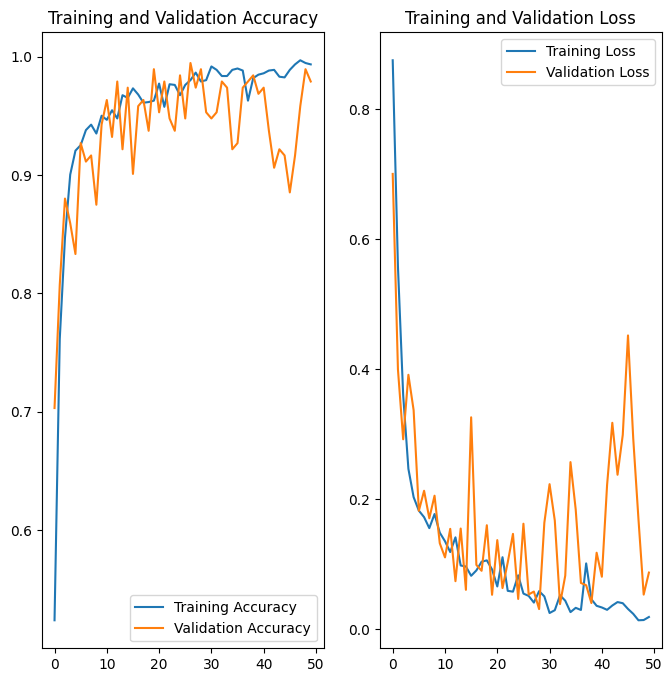

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
predicted label: Potato___Late_blight


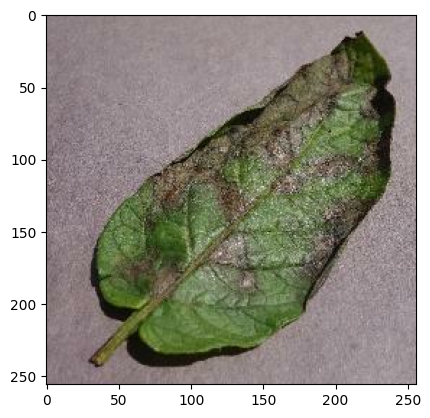

In [60]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [49]:
	
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


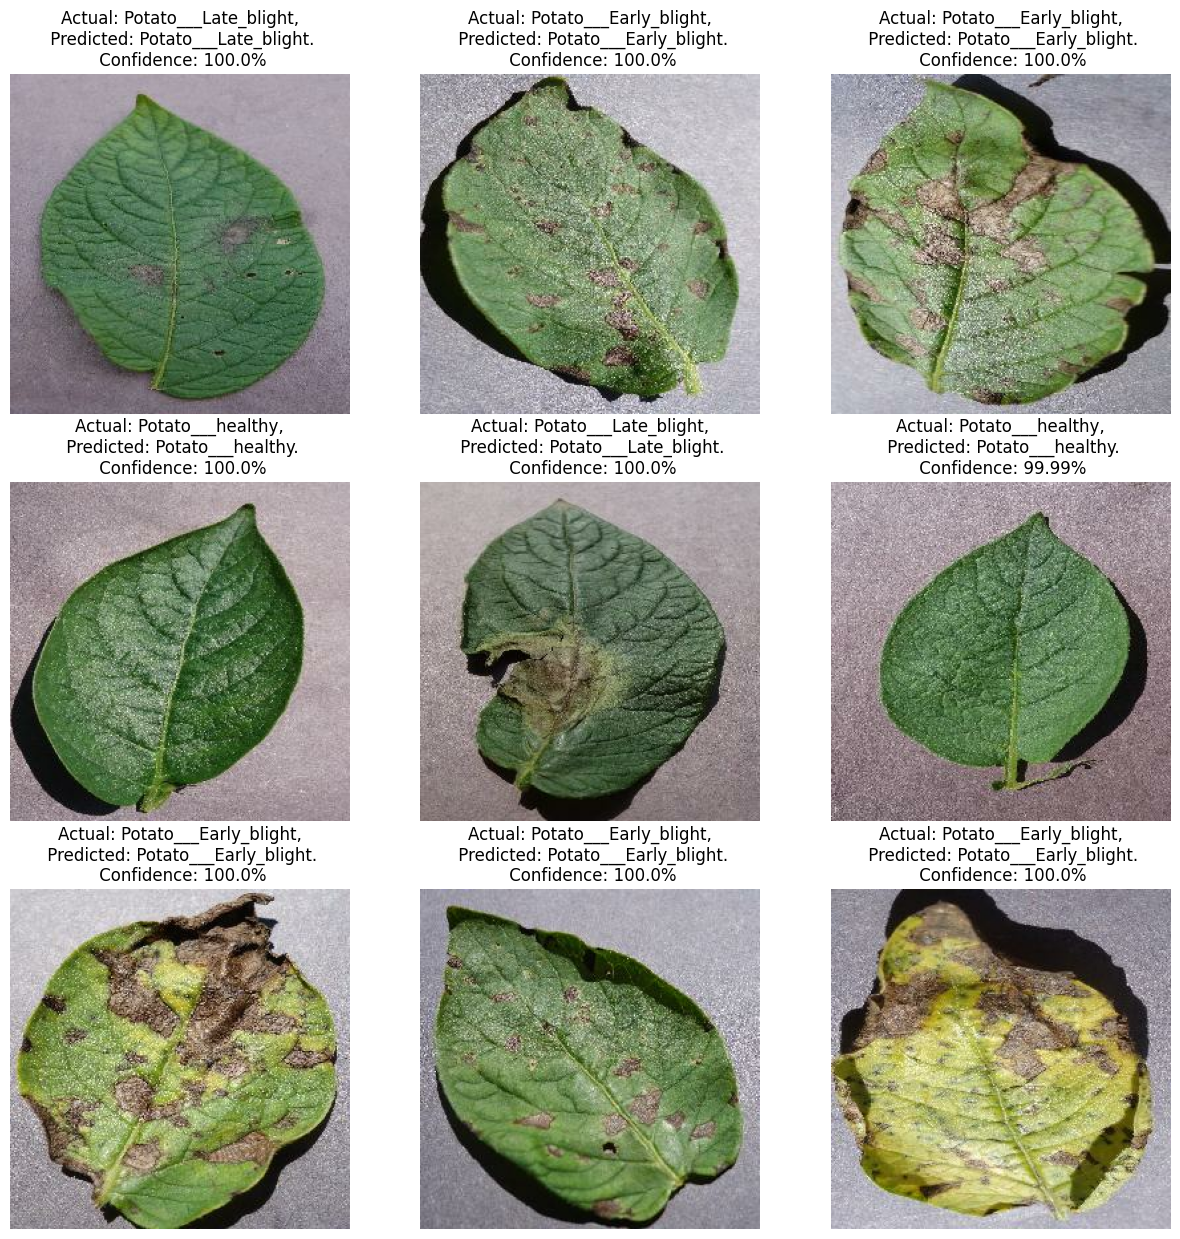

In [69]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


In [79]:
import os
import tensorflow as tf

# Define the directory and filename
save_dir = "/Users/yesaswimadabattula/Documents/potato_disease_detection/models"
save_path = os.path.join(save_dir, "1.keras")

# Create directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save the model in .keras format (recommended for TF >= 2.12)
model.save(save_path)

print(f"✅ Model saved successfully at: {save_path}")


✅ Model saved successfully at: /Users/yesaswimadabattula/Documents/potato_disease_detection/models/1.keras


In [67]:
model.save("../potatoes.h5")


In [ ]:
#to load the model
from tensorflow.keras.models import load_model
model = load_model("/Users/yesaswimadabattula/Documents/potato_disease_detection/models/1.keras")


/Users/yesaswimadabattula/Documents/potato_disease_detection/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
